### Import the lib that i need.


In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2

### Get the best-fit transform between corresponding  points A->B

    Input:
          A: point set 1
          B: point set 2
      
    Output:
          T: homogeneous transformation matrix
          R: rotation matrix
          t: column vector

In [5]:
def best_fit_transform(A, B):
    
    assert len(A) == len(B)

    # translate the points of A and B to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    shifted_A = A - centroid_A
    shifted_B = B - centroid_B

    # rotation matrix
    W = np.dot(shifted_B.T, shifted_A)
    U, s, VT = np.linalg.svd(W)
    R = np.dot(U, VT)

    # special reflection case
    if np.linalg.det(R) < 0:
       VT[2,:] *= -1
       R = np.dot(U, VT)


    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(3)
    T[0:2, 0:2] = R
    T[0:2, 2] = t

    return T, R, t

### Find the nearest (Euclidean) neighbor in dst for each point in src

    Input:
        src: point set 1
        dst: point set 2
        
    Output:
        distances: Euclidean distances (errors) of the nearest neighbor
        indecies: dst indecies of the nearest neighbor

In [6]:
def nearest_neighbor(src, dst):
    indecies = np.zeros(src.shape[0], dtype=np.int)
    distances = np.zeros(src.shape[0])
    for i, s in enumerate(src):
        min_dist = np.inf
        for j, d in enumerate(dst):
            dist = np.linalg.norm(s-d)
            if dist < min_dist:
                min_dist = dist
                indecies[i] = j
                distances[i] = dist    
    return distances, indecies

### The Iterative Closest Point method

    Input:
        A: point set 1
        B: point set 2
        init_pose: homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
        
    Output:
        T: final homogeneous transformation
        distances: Euclidean distances (errors) of the nearest neighbor

In [7]:
def icp(A, B, init_pose=None, max_iterations=60, tolerance=0.001):
    # make points homogeneous, copy them so as to maintain the originals
    src = np.ones((3,A.shape[0]))
    dst = np.ones((3,B.shape[0]))
    src[0:2,:] = np.copy(A.T)
    dst[0:2,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbours between the current source and destination points
        distances, indices = nearest_neighbor(src[0:2,:].T, dst[0:2,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[0:2,:].T, dst[0:2,indices].T)

        # update the current source
    # refer to "Introduction to Robotics" Chapter2 P28. Spatial description and transformations
        src = np.dot(T, src)

        # check error
        mean_error = np.sum(distances) / distances.size
        if abs(prev_error-mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculcate final tranformation
    T,_,_ = best_fit_transform(A, src[0:2,:].T)

    return T, distances

### Draw dots on the image
    
    Input: 
        img: The image source where we want to add the dots
        dot: points set of our dots
        color: The color of our dots
        
    Output:
        w: Image with dots on it
        
        

In [8]:
def drawDot(img,dot,color=(255,0,0)):
    w = img.copy()
    for i in range(len(dot)):
        x = dot[i][0]
        y = dot[i][1]
        w = cv2.circle(w, (y,x),2 ,color,2)
        
    """cv2.imshow("img",w) 
    cv2.waitKey(0) 
    cv2.destroyAllWindows()"""
    plt.imshow(w)
    
    return w

# Task 1

In [9]:
import random
def task_1():
    img = cv2.imread('./data/hand.jpg')
    
    # Get landmarj points
    with open("./data/hand_landmarks.txt") as fh:
        landmark = []
        for line in fh:
            line = line.strip('()\n')
            line = line.split(',')
            c = tuple(int(x) for x in line)
            landmark.append(c)

    landmark = np.array(landmark)
    """mirror = np.identity(2)
    mirror[0] = [-1,0]    
    landmark = mirror.dot(landmark.T).T
    for i in range(landmark.shape[0]):
        landmark[i][0] += 800"""   
    
    landmark = landmark.astype(int)
    """drawDot(img,landmark)"""
    
    
    # get the contour of the hand
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    canny = cv2.Canny(img_gray, 60, 100, apertureSize  = 3)
    
    # Randomly get points from canny
    edges = []
    for i in range(canny.shape[0]):
        for j in range(canny.shape[1]):
            if canny[i][j] != 0:
                edges.append([i,j])
    sample = random.sample(edges, len(landmark)+100)
    sample = np.array(sample)
    
    
    T, distance = icp(landmark,sample)
    print("Transformation:")
    print(T)
    
    # pad 1
    landmark_pad_one = []
    
    for i in range(landmark.shape[0]):        
        landmark_pad_one.append(np.append(landmark[i],[1])) 
    
    landmark_pad_one = np.array(landmark_pad_one)
    newPos_pad_one = T.dot(landmark_pad_one.T)
    
    newPos_pad_one = newPos_pad_one.astype(int)
    newPos_pad_one=newPos_pad_one.T
    
    
    w = drawDot(img,newPos_pad_one)

Transformation:
[[  0.93953452  -0.3424542  -23.14430652]
 [  0.3424542    0.93953452  -0.69501825]
 [  0.           0.           1.        ]]


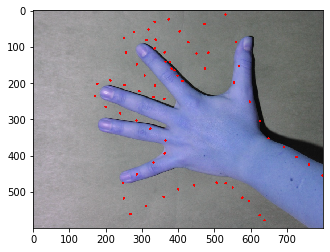

In [10]:
task_1()